# 22.11.2024

In [1]:
from matplotlib import pyplot as plt
import scipy.stats as sps
import numpy as np
import math

from statsmodels.stats.proportion import proportion_confint 

from tqdm import tqdm, trange
from functools import lru_cache
from typing import Literal, Callable, Sequence
from multipledispatch import dispatch
from __future__ import annotations

In [2]:
NS = [10, 50, 100, 150, 200, 500]
N = 10 ** 3
FRR = 0.05
FAR = 0.05

T = 5

In [3]:
@lru_cache
def get_distributions(E: float = 0, D: float = 1) -> dict[str, sps.rv_continuous]:
    unif_scale = 2 * math.sqrt(3 * D)
    unif_loc = E - unif_scale / 2
    return {
        'Norm': sps.norm(loc=E, scale=math.sqrt(D)),
        'Uniform': sps.uniform(loc=unif_loc, scale=unif_scale),
        'Exp': sps.expon(loc=E - math.sqrt(D), scale=math.sqrt(D))
    }

Класс интервала (для удобства и красоты)

In [4]:
def isnumber(x):
    try:
        iter(x)
    except TypeError:
        return np.isreal(x)
    return False

class Interval:
    @dispatch((float, int, np.floating, np.integer), (float, int, np.floating, np.integer))
    def __init__(self, a: float | int | np.floating | np.integer, b: float | int | np.floating | np.integer):
        if a >= b:
            raise ValueError('Left boundary should be smaller than right boundary.')
        self.a = a
        self.b = b
    
    @dispatch((list, np.ndarray))
    def __init__(self, a: list[float | int | np.floating | np.integer] | np.ndarray[float | int | np.floating | np.integer]):
        if isnumber(a[0]) and isnumber(a[1]):
            if a[0] >= a[1]:
                raise ValueError('Left boundary should be smaller than right boundary.')
            self.a = a[0]
            self.b = a[1]
        else:
            raise ValueError('Expected a list of numbers.')
    
    @dispatch((float, int, np.floating, np.integer))
    def contains(self, x: float | int | np.floating | np.integer) -> bool:
        return self.a < x < self.b
    
    @dispatch((list, np.ndarray))
    def contains(self, x: list[float | int | np.floating | np.integer] | np.ndarray[float | int | np.floating | np.integer]) -> list[bool]:
        return [self.a < x_ < self.b for x_ in x]

    def issubset(self, i: Interval):
        return self.a > i.a and self.b < i.b

    def __repr__(self, precision: int | None = None):
        if precision is None:
            return f'[{self.a}; {self.b}]'
        else:
            return f'[{self.a:.{precision}f}; {self.b:.{precision}f}]'

Функция тестирования функции проверки сложных статистических гипотез

In [5]:
def test_solution(what: Callable,
                  frr: float,
                  far: float,
                  hypothesis_kwargs: dict[str],
                  distributions: dict[str, sps.rv_continuous],
                  ax: plt.Axes | None = None,
                  include_label: Literal['quantile', 'iqr'] | None = None):
    res = {d: [] for d in distributions}
    interval_res = {d: [] for d in distributions}
    for n in NS:
        for d_name, distro in distributions.items():
            cur_res = 0
            for _ in range(N):
                cur_res += not what(distro.rvs(size=n), frr=frr, far=far, **hypothesis_kwargs)
            res[d_name].append(cur_res / N)
            interval_res[d_name].append(proportion_confint(cur_res, N))
    
    # Plot the results
    if ax is None:
        ax = plt.gca()
    ax.axhline(frr, linestyle='--', color='gray', alpha=0.5)
    for distr_name, distribution in distributions.items():
        match include_label:
            case None:
                label = distr_name
            case 'quantile':
                q = hypothesis_kwargs['q']  # Will raise an error if not provided and it's okay
                label = f'{distr_name}, $x_{{{q}}}$ = {distribution.ppf(q):.2f}'
            case 'iqr':
                p = hypothesis_kwargs['p']  # Will raise an error if not provided and it's okay
                iqr = Interval(distribution.ppf(1 - p), distribution.ppf(p))
                label = f'{distr_name}, p-IQR = {iqr.__repr__(2)}'
            case _:
                label = distr_name
        y_err = list(map(lambda arr: np.abs(np.subtract(arr, res[distr_name])), zip(*interval_res[distr_name])))
        ax.errorbar(NS, res[distr_name], yerr=y_err, fmt='o-', capsize=3, label=label)
    E, D = list(distributions.items())[0][1].stats('mv')
    ax.title.set_text(f'$M[r] = {round(E, 1):.1f}, D[r] = {round(D, 1):.1f}$')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale('log')
    ax.legend()

Функция проверки сложной гипотезы об интерквантильном промежутке. Возвращает `True`, если следует принять гипотезу $H_0: J_p \subset J_0$ с заданными $\text{FRR}$ и $\text{FAR}$.

In [6]:
def check_interquantile_interval(sample: Sequence, frr: float, far: float, p: float, I: Interval) -> bool:
    n = len(sample)
    m = sum(I.contains(sample))
    p_min, _ = proportion_confint(m, n, alpha=frr)
    if p < p_min:
        return True
    _, p_max = proportion_confint(m, n, alpha=far)
    if p_max < p:
        return False
    else:
        return False

## Task 2

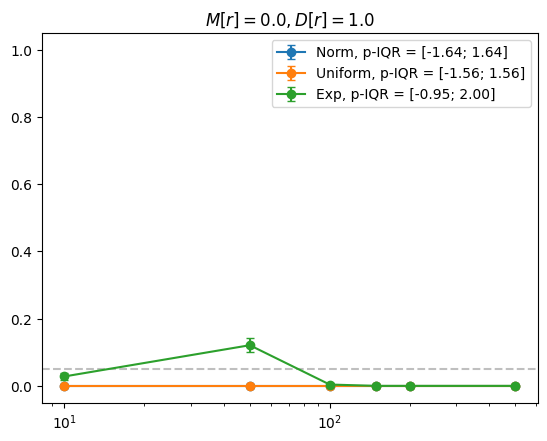

In [7]:
test_solution(check_interquantile_interval, FRR, FAR, hypothesis_kwargs={'p': 0.95, 'I': Interval(-T, T)}, distributions=get_distributions(E=0, D=1), include_label='iqr')

In [8]:
STEP = 0.2
SIGMAS = np.linspace(1, T, num=int((T - 1) // STEP) + 2)
num_tries = len(SIGMAS)
SIGMAS, num_tries
I = Interval(-T, T)

100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


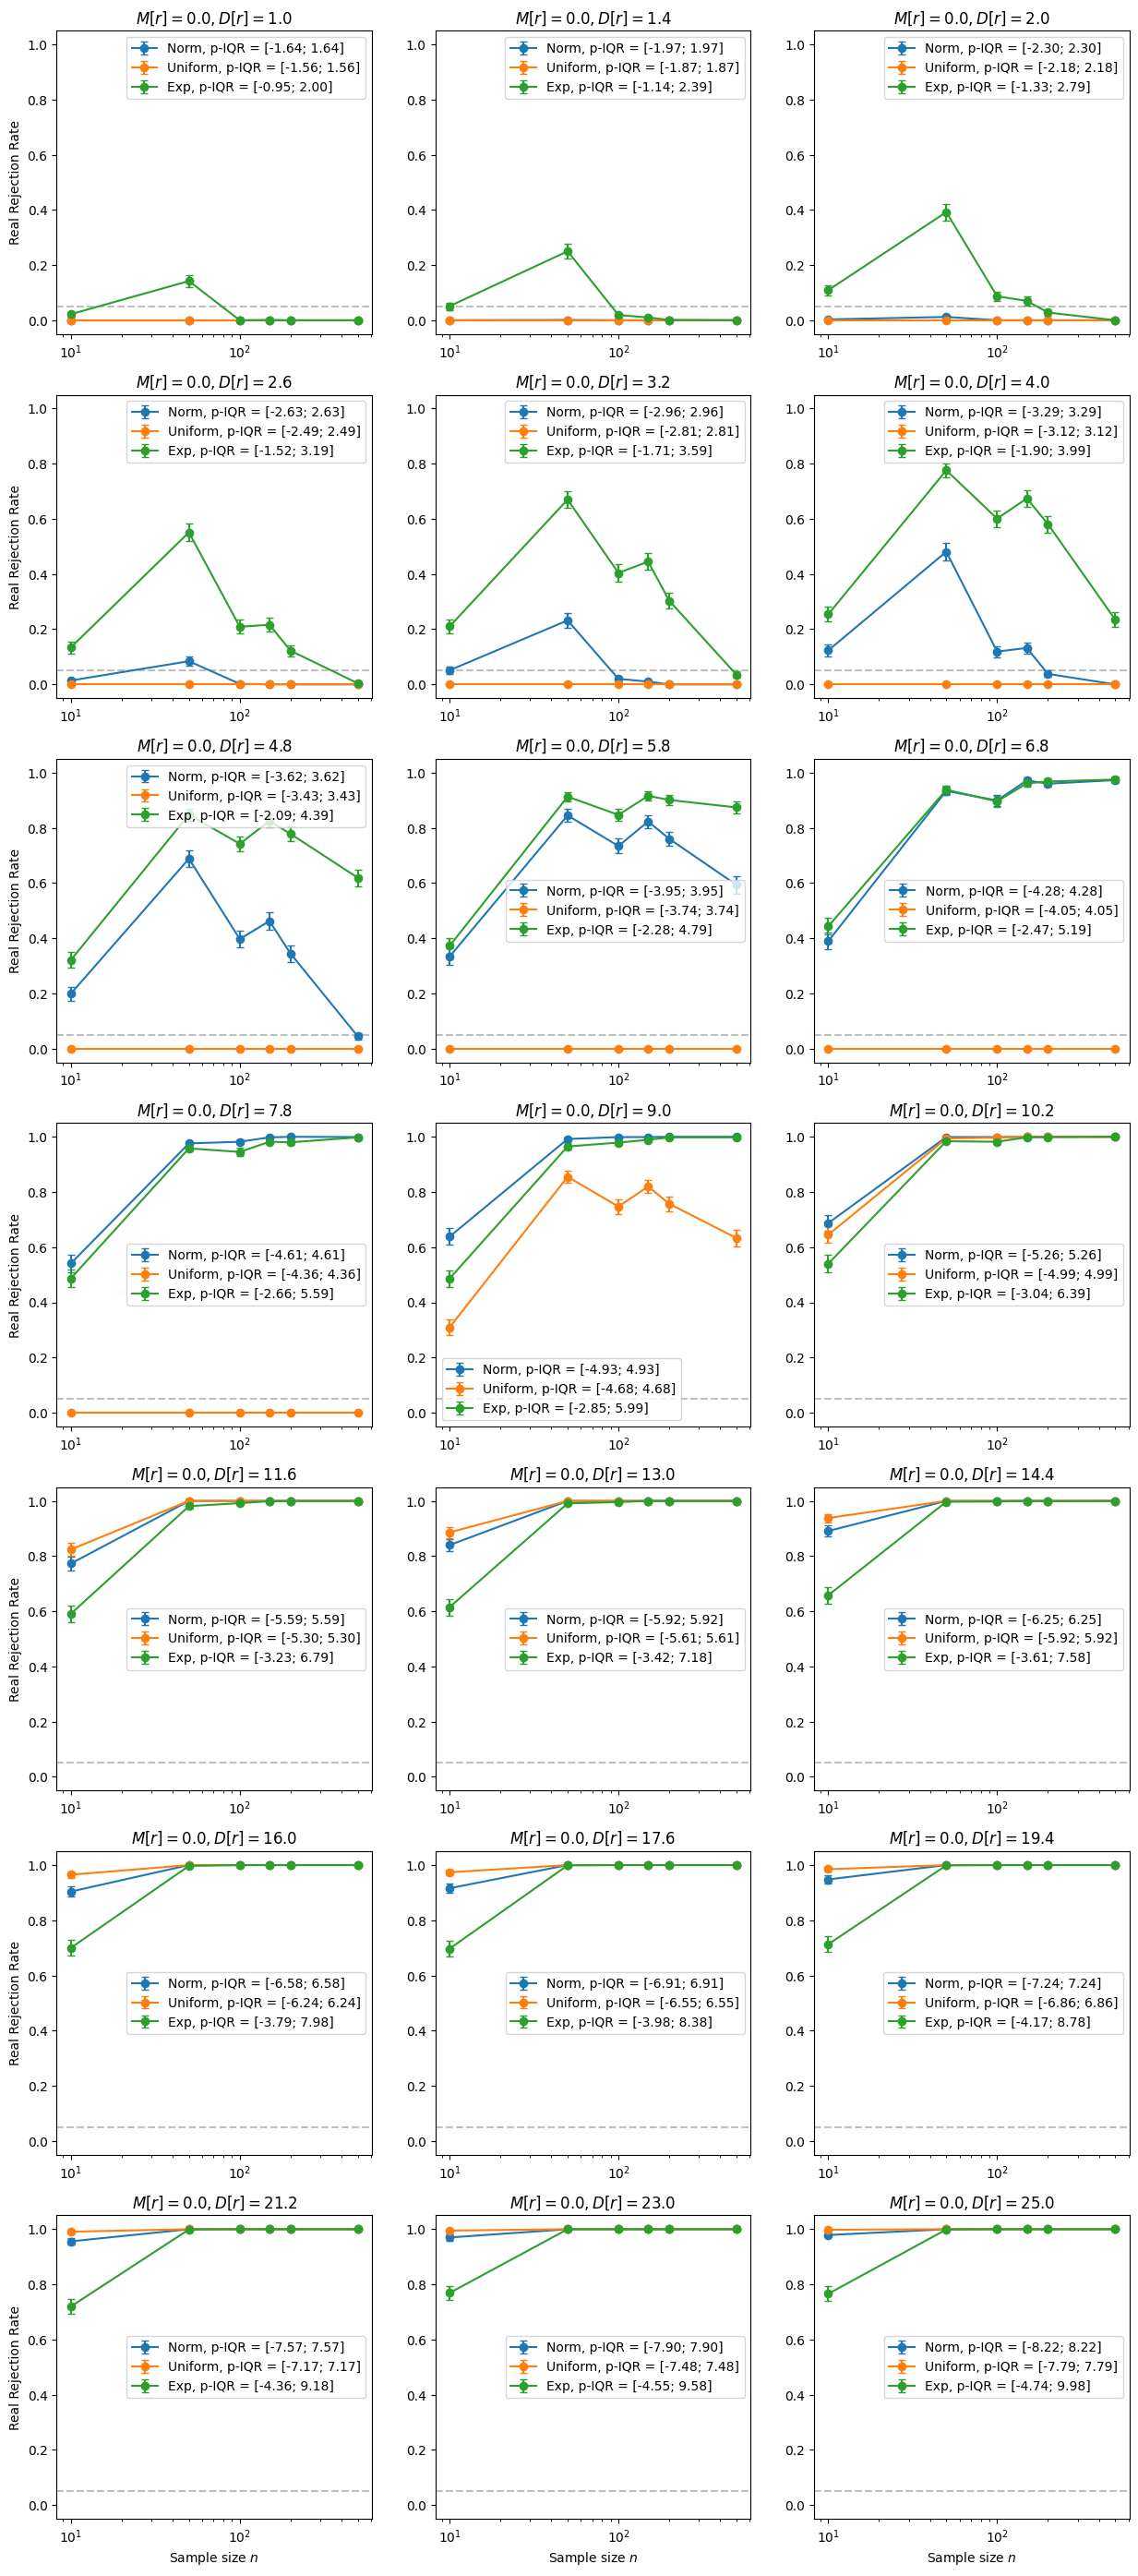

In [9]:
_, axes = plt.subplots(7, 3, figsize=(5 * 3, 5 * 7))
for i, std in tqdm(enumerate(SIGMAS), total=num_tries):
    ax: plt.Axes = axes[i // 3][i % 3]
    test_solution(check_interquantile_interval, frr=FRR, far=FAR, hypothesis_kwargs={'p': 0.95, 'I': I}, distributions=get_distributions(E=0, D=std ** 2), ax=ax, include_label='iqr')
for i in range(7):
    axes[i][0].set_ylabel('Real Rejection Rate')
for i in range(3):
    axes[6][i].set_xlabel('Sample size $n$')
plt.show()